In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from collections import defaultdict


In [22]:
def set_seeds(seed=42):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set random seeds for reproducibility
set_seeds()

class DeepNLPDataset(Dataset):
    """Dataset with more realistic NLP preprocessing"""
    def __init__(self, sentences, groups, max_length=32):
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length
        
        # Tokenize all sentences
        self.encodings = self.tokenizer(
            sentences,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        
        self.groups = groups
        
    def __len__(self):
        return len(self.groups)
    
    def __getitem__(self, idx):
        item = {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'group': self.groups[idx]
        }
        return item

class DeepNLPModel(nn.Module):
    """Deep NLP model with multiple types of regularization"""
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, 
                 num_layers=12, num_heads=4, dropout_rates=[0.1, 0.14, 0.18, 0.22, 0.26, 0.3, 0.34, 0.38, 0.42, 0.46, 0.5, 0.54]):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embedding_dim)
        
        # Create layers with different regularization strategies
        self.layers = nn.ModuleList([
            TransformerLayerWithRegularization(
                embedding_dim,
                hidden_dim,
                num_heads,
                dropout_rate=dropout_rates[i],
                layer_idx=i
            ) for i in range(num_layers)
        ])
        
        self.final_norm = nn.LayerNorm(embedding_dim)
        
        # Store intermediate representations and regularization losses
        self.intermediate_representations = []
        self.reg_losses = defaultdict(list)
        
    def forward(self, input_ids, attention_mask, return_intermediates=False):
        # Reset storage
        self.intermediate_representations = []
        self.reg_losses = defaultdict(list)
        
        # Initial embedding
        x = self.embedding(input_ids)
        x = self.pos_encoder(x)
        x = x * attention_mask.unsqueeze(-1)
        
        self.intermediate_representations.append(('embedding', x.detach()))
        
        # Process through layers
        for i, layer in enumerate(self.layers):
            x, layer_reg_losses = layer(x, attention_mask)
            self.intermediate_representations.append((f'layer_{i}', x.detach()))
            
            # Collect regularization losses
            for loss_name, loss_value in layer_reg_losses.items():
                self.reg_losses[f'layer_{i}_{loss_name}'].append(loss_value)
        
        # Final normalization
        x = self.final_norm(x)
        self.intermediate_representations.append(('final', x.detach()))
        
        # Pool to get sentence representations
        sentence_repr = (x * attention_mask.unsqueeze(-1)).sum(dim=1)
        sentence_repr = sentence_repr / attention_mask.sum(dim=1, keepdim=True)
        
        if return_intermediates:
            return sentence_repr, self.intermediate_representations, self.reg_losses
        return sentence_repr

class TransformerLayerWithRegularization(nn.Module):
    """Transformer layer with explicit tracking of different regularization effects"""
    def __init__(self, dim, hidden_dim, num_heads, dropout_rate, layer_idx):
        super().__init__()
        
        self.layer_idx = layer_idx
        self.attention = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )
        
        # Different types of regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm1 = nn.LayerNorm(dim)
        self.layer_norm2 = nn.LayerNorm(dim)
        
        # L2 regularization strength increases with layer depth
        self.l2_strength = 0.01 * (layer_idx + 1)
        
    def forward(self, x, attention_mask):
        reg_losses = {}
        
        # Self-attention with regularization
        attended, _ = self.attention(x, x, x, 
                                   key_padding_mask=~attention_mask.bool())
        attended = self.dropout(attended)
        
        # First residual connection and norm
        x = self.layer_norm1(x + attended)
        reg_losses['attention_l2'] = self.l2_strength * torch.norm(attended)
        
        # Feed-forward with regularization
        ff_out = self.feed_forward(x)
        ff_out = self.dropout(ff_out)
        
        # Second residual connection and norm
        x = self.layer_norm2(x + ff_out)
        reg_losses['ff_l2'] = self.l2_strength * torch.norm(ff_out)
        
        return x, reg_losses

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class SimilarityAnalyzer:
    """Analyze similarities across layers and regularization effects"""
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        
    def compute_layer_similarities(self):
        loader = DataLoader(self.dataset, batch_size=len(self.dataset))
        batch = next(iter(loader))
        
        self.model.eval()
        with torch.no_grad():
            _, intermediates, reg_losses = self.model(
                batch['input_ids'],
                batch['attention_mask'],
                return_intermediates=True
            )
        
        similarities = {}
        for name, representations in intermediates:
            # Get sentence-level representations
            sent_repr = (representations * batch['attention_mask'].unsqueeze(-1)).sum(dim=1)
            sent_repr = sent_repr / batch['attention_mask'].sum(dim=1, keepdim=True)
            
            # Compute both dot product and cosine similarities
            dot_prod = torch.matmul(sent_repr, sent_repr.t())
            norms = torch.norm(sent_repr, p=2, dim=1)
            cosine = dot_prod / torch.outer(norms, norms)
            
            similarities[name] = {
                'dot_product': dot_prod.cpu().numpy(),
                'cosine': cosine.cpu().numpy(),
                'norms': norms.cpu().numpy()
            }
            
        return similarities, reg_losses

    def visualize_layer_effects(self, similarities):
        num_layers = len(similarities)
        fig, axes = plt.subplots(3, num_layers, figsize=(5*num_layers, 15))
        
        for i, (name, sim_dict) in enumerate(similarities.items()):
            # Plot dot products with square aspect ratio
            sns.heatmap(sim_dict['dot_product'], ax=axes[0, i], 
                    cmap='coolwarm', center=0, square=True)  # Added square=True
            axes[0, i].set_title(f'{name}\nDot Products')
            
            # Plot cosine similarities with square aspect ratio
            sns.heatmap(sim_dict['cosine'], ax=axes[1, i],
                    cmap='coolwarm', vmin=-1, vmax=1, square=True)  # Added square=True
            axes[1, i].set_title('Cosine Similarities')
            
            # Plot norm distributions
            axes[2, i].hist(sim_dict['norms'], bins=20)
            axes[2, i].set_title('Embedding Norms')
        
        plt.tight_layout()
        return fig

def run_deep_analysis(sentences, groups):
    # Create dataset
    dataset = DeepNLPDataset(sentences, groups)
    
    # Initialize model
    vocab_size = dataset.tokenizer.vocab_size
    model = DeepNLPModel(vocab_size)
    
    # Create analyzer
    analyzer = SimilarityAnalyzer(model, dataset)
    
    # Compute and visualize similarities
    similarities, reg_losses = analyzer.compute_layer_similarities()
    fig = analyzer.visualize_layer_effects(similarities)
    
    return similarities, reg_losses, fig

# Example sentences from before, but let's make them longer and more complex
sentences = [
    # Animal group (more complex sentences)
    "The domestic cat silently stalks and chases the frightened mouse across the wooden floor",
    "A large brown dog eagerly chases the neighbor's cat through the suburban garden",
    "The majestic lion carefully hunts the swift gazelle across the African savanna",
    "A gray wolf pack strategically hunts the young deer in the dense forest",
    "The Bengal tiger stealthily stalks its unsuspecting prey in the jungle undergrowth",
    "The red fox skillfully catches the wild rabbit near the forest edge",
    
    # Nature group (more complex sentences)
    "The ancient oak tree gently sways in the warm summer wind beneath blue skies",
    "Colorful wildflowers bloom brilliantly in the fresh spring morning sunshine",
    "Tall grass waves rhythmically in the bright sunlight across rolling meadows",
    "The mighty river flows steadily downstream through deep mountain valleys",
    "Green leaves rustle gently in the cool autumn breeze high above ground",
    "Heavy rain falls softly on the quiet forest floor during the storm",
    
    # Human group (more complex sentences)
    "The experienced teacher carefully writes complex equations on the blackboard",
    "A dedicated student intensely reads the challenging book in the library",
    "The skilled worker methodically builds the modern house using new techniques",
    "The professional chef expertly cooks the gourmet meal in the restaurant",
    "An inspired artist creatively paints the detailed canvas in the studio",
    "The compassionate doctor efficiently helps patients in the busy hospital"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0] * 6 + [1] * 6 + [2] * 6

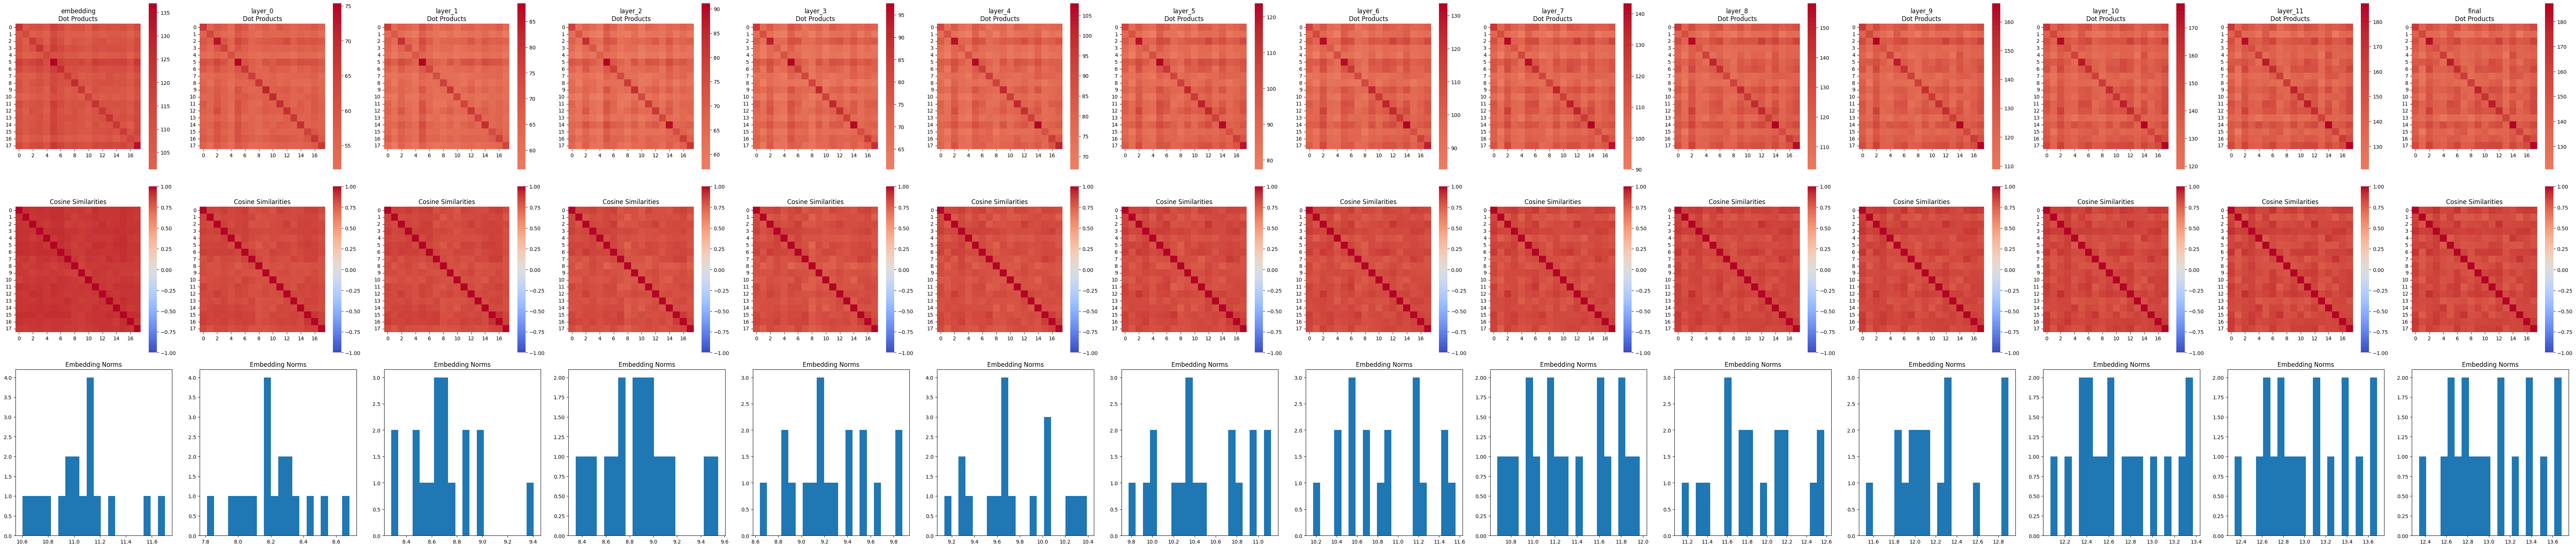

In [23]:
similarities, reg_losses, fig = run_deep_analysis(sentences, groups)
plt.show()

1. **Embedding Layer** (First column):

- **Dot Products** (Top): Shows very high values (110-135 range)
  * Think of this as the raw strength of relationships between sentences
  * Like comparing sentences with their original word meanings
  * Brighter red means stronger relationships

- **Cosine** (Middle): Shows clear block patterns
  * The bright red blocks along diagonal show sentences in same group (animals, nature, human) are very similar
  * Like saying "animal sentences really look like other animal sentences"

2. **Layer 0** (Second column):
- **Dot Products**: Values drop (50-65 range)
  * The model starts processing the sentences
  * Like adding context to the basic word meanings
  * Still shows relationships but not as intense

- **Cosine**: Pattern starts to change
  * Groups still visible but less sharp
  * Like saying "we're starting to see more nuanced relationships"

3. **Layer 1 & 2** (Middle columns):
- **Dot Products**: Values continue changing (55-75, then 60-85)
  * Model is further processing and refining
  * Like adding more sophisticated understanding
  * Note how the scales keep changing

- **Cosine**: Patterns become more defined
  * Group relationships become clearer again
  * Like the model is getting better at saying "these sentences really are about similar things"

4. **Final Layer** (Last column):
- **Dot Products**: Settles at new scale (60-85)
  * Final representation of sentence relationships
  * But notice how different the scale is from where we started

- **Cosine**: Shows clear final groupings
  * Clear blocks along diagonal
  * But because it's normalized, we can't see how much the actual values changed from the beginning

The key point is:
- Dot products show how the actual values change dramatically through layers
- Cosine similarity always shows values between -1 and 1
- So while cosine might make it look like relationships stay similar, the dot products show us they're actually changing a lot
- It's like cosine similarity is hiding all the dramatic changes we can see in the dot products

This is exactly what the paper warns about - cosine similarity can make it look like relationships are stable when they're actually changing quite dramatically through the network.

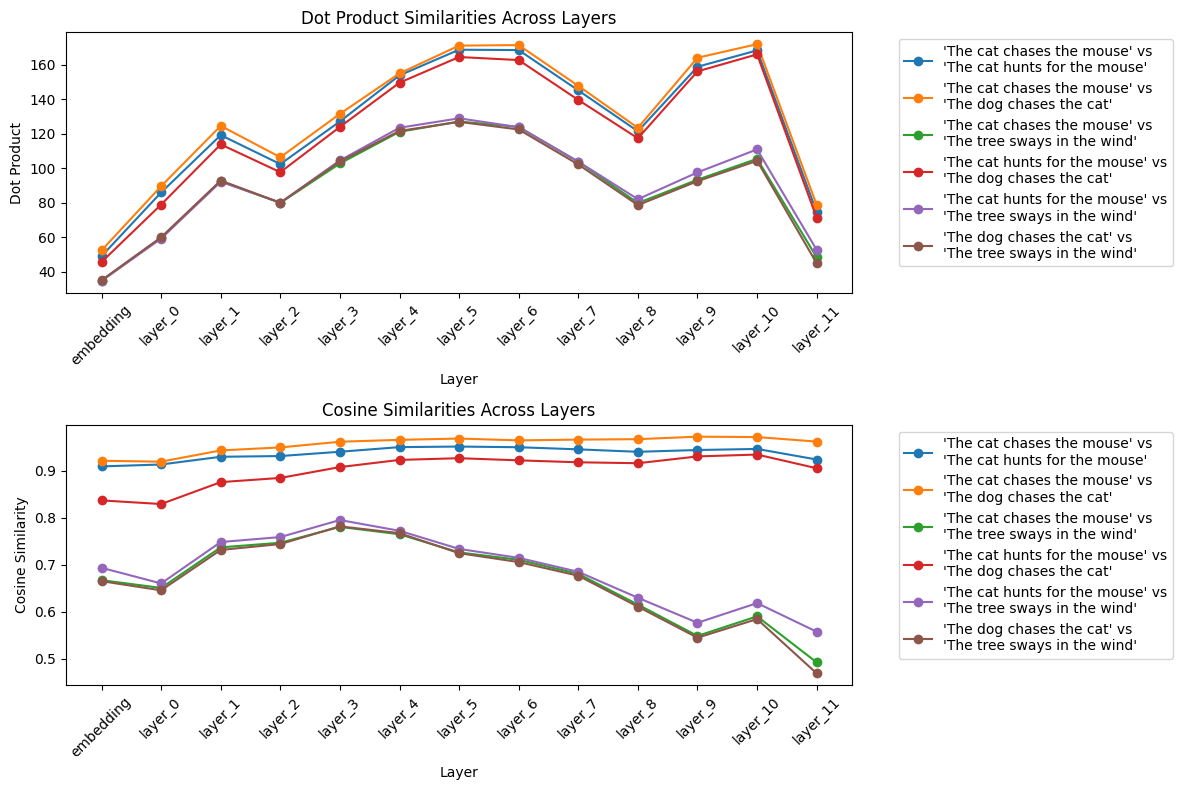


Detailed Similarity Changes:

Layer: embedding
Dot product (cat chases vs cat hunts): 49.011
Cosine sim (cat chases vs cat hunts): 0.909
Dot product (cat chases vs tree sways): 34.782
Cosine sim (cat chases vs tree sways): 0.667

Layer: layer_0
Dot product (cat chases vs cat hunts): 85.935
Cosine sim (cat chases vs cat hunts): 0.913
Dot product (cat chases vs tree sways): 59.725
Cosine sim (cat chases vs tree sways): 0.651

Layer: layer_1
Dot product (cat chases vs cat hunts): 119.207
Cosine sim (cat chases vs cat hunts): 0.930
Dot product (cat chases vs tree sways): 92.330
Cosine sim (cat chases vs tree sways): 0.737

Layer: layer_2
Dot product (cat chases vs cat hunts): 102.387
Cosine sim (cat chases vs cat hunts): 0.931
Dot product (cat chases vs tree sways): 79.915
Cosine sim (cat chases vs tree sways): 0.747

Layer: layer_3
Dot product (cat chases vs cat hunts): 127.137
Cosine sim (cat chases vs cat hunts): 0.940
Dot product (cat chases vs tree sways): 102.755
Cosine sim (cat cha

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_similarities(sentences, model_name='bert-base-uncased'):
    """Compare dot product and cosine similarities for a set of sentences"""
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    
    # Storage for layer-wise embeddings
    layer_embeddings = []
    
    def hook_fn(module, input, output):
        # Store the layer output, detached from computation graph
        layer_embeddings.append(output[0].detach())
    
    # Register hooks for each layer
    for layer in model.encoder.layer:
        layer.register_forward_hook(hook_fn)
    
    # Tokenize sentences
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    
    # Get embeddings from each layer
    with torch.no_grad():
        _ = model(**inputs)
        
    # Process embeddings from each layer
    results = []
    
    # Add initial embedding layer
    with torch.no_grad():
        initial_embeddings = model.embeddings(inputs['input_ids'])
        mean_embeddings = (initial_embeddings * inputs['attention_mask'].unsqueeze(-1)).sum(1) / inputs['attention_mask'].sum(-1).unsqueeze(-1)
        results.append(("embedding", mean_embeddings))
    
    # Process each layer's embeddings
    for idx, layer_output in enumerate(layer_embeddings):
        # Mean pooling
        mask = inputs['attention_mask'].unsqueeze(-1)
        mean_embeddings = (layer_output * mask).sum(1) / mask.sum(1)
        results.append((f"layer_{idx}", mean_embeddings))
    
    # Compute similarities for each layer
    similarities = []
    for layer_name, embeddings in results:
        # Compute dot product
        dot_prod = torch.matmul(embeddings, embeddings.T)
        
        # Compute cosine similarity
        norms = torch.norm(embeddings, p=2, dim=1)
        cosine_sim = dot_prod / torch.outer(norms, norms)
        
        # Store results, converting to numpy arrays
        similarities.append({
            'layer': layer_name,
            'dot_product': dot_prod.cpu().numpy(),
            'cosine': cosine_sim.cpu().numpy(),
            'norms': norms.cpu().numpy()
        })
    
    return similarities

def plot_sentence_similarities(similarities, sentences):
    """Plot similarity changes through layers for specific sentence pairs"""
    n_layers = len(similarities)
    
    # Prepare data for plotting
    layers = [sim['layer'] for sim in similarities]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot dot products
    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            dot_products = [sim['dot_product'][i,j] for sim in similarities]
            ax1.plot(range(n_layers), dot_products, 
                    label=f"'{sentences[i]}' vs\n'{sentences[j]}'",
                    marker='o')
    
    ax1.set_title('Dot Product Similarities Across Layers')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Dot Product')
    ax1.set_xticks(range(n_layers))
    ax1.set_xticklabels(layers, rotation=45)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot cosine similarities
    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            cosine_sims = [sim['cosine'][i,j] for sim in similarities]
            ax2.plot(range(n_layers), cosine_sims, 
                    label=f"'{sentences[i]}' vs\n'{sentences[j]}'",
                    marker='o')
    
    ax2.set_title('Cosine Similarities Across Layers')
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Cosine Similarity')
    ax2.set_xticks(range(n_layers))
    ax2.set_xticklabels(layers, rotation=45)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig

# Example usage
test_sentences = [
    "The cat chases the mouse",         # Basic animal action
    "The cat hunts for the mouse",      # Similar meaning, different words
    "The dog chases the cat",           # Related but different
    "The tree sways in the wind"        # Completely different topic
]

# Run analysis
similarities = compare_similarities(test_sentences)

# Plot results
fig = plot_sentence_similarities(similarities, test_sentences)
plt.show()

# Print some specific comparisons
print("\nDetailed Similarity Changes:")
for layer_idx, sim in enumerate(similarities):
    print(f"\nLayer: {sim['layer']}")
    print(f"Dot product (cat chases vs cat hunts): {sim['dot_product'][0,1]:.3f}")
    print(f"Cosine sim (cat chases vs cat hunts): {sim['cosine'][0,1]:.3f}")
    print(f"Dot product (cat chases vs tree sways): {sim['dot_product'][0,3]:.3f}")
    print(f"Cosine sim (cat chases vs tree sways): {sim['cosine'][0,3]:.3f}")

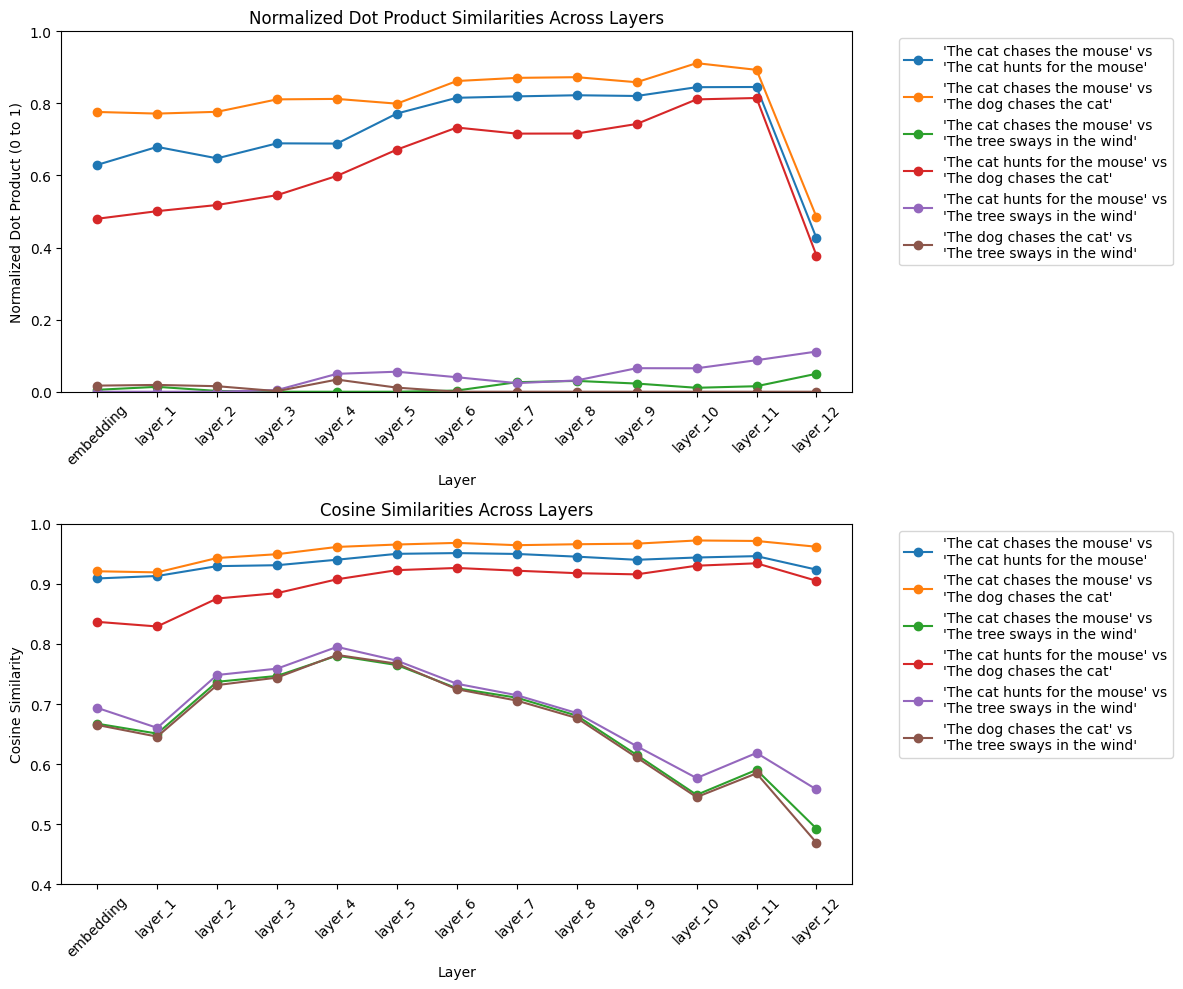


Detailed Similarity Changes:

Layer: embedding
Normalized Dot product (cat chases vs cat hunts): 0.629
Cosine sim (cat chases vs cat hunts): 0.909
Normalized Dot product (cat chases vs tree sways): 0.005
Cosine sim (cat chases vs tree sways): 0.667

Layer: layer_1
Normalized Dot product (cat chases vs cat hunts): 0.679
Cosine sim (cat chases vs cat hunts): 0.913
Normalized Dot product (cat chases vs tree sways): 0.014
Cosine sim (cat chases vs tree sways): 0.651

Layer: layer_2
Normalized Dot product (cat chases vs cat hunts): 0.648
Cosine sim (cat chases vs cat hunts): 0.930
Normalized Dot product (cat chases vs tree sways): 0.002
Cosine sim (cat chases vs tree sways): 0.737

Layer: layer_3
Normalized Dot product (cat chases vs cat hunts): 0.689
Cosine sim (cat chases vs cat hunts): 0.931
Normalized Dot product (cat chases vs tree sways): 0.000
Cosine sim (cat chases vs tree sways): 0.747

Layer: layer_4
Normalized Dot product (cat chases vs cat hunts): 0.689
Cosine sim (cat chases v

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_similarities(sentences, model_name='bert-base-uncased'):
    """Compare dot product and cosine similarities for a set of sentences"""
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    
    # Storage for layer-wise embeddings
    layer_embeddings = []
    
    def hook_fn(module, input, output):
        # Store the layer output, detached from computation graph
        layer_embeddings.append(output[0].detach())
    
    # Register hooks for each layer
    for layer in model.encoder.layer:
        layer.register_forward_hook(hook_fn)
    
    # Tokenize sentences
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    
    # Get embeddings from each layer
    with torch.no_grad():
        _ = model(**inputs)
        
    # Process embeddings from each layer
    results = []
    
    # Add initial embedding layer
    with torch.no_grad():
        initial_embeddings = model.embeddings(inputs['input_ids'])
        # Mean pooling
        mean_embeddings = (initial_embeddings * inputs['attention_mask'].unsqueeze(-1)).sum(1) / inputs['attention_mask'].sum(-1, keepdim=True)
        results.append(("embedding", mean_embeddings))
    
    # Process each layer's embeddings
    for idx, layer_output in enumerate(layer_embeddings):
        # Mean pooling
        mask = inputs['attention_mask'].unsqueeze(-1)
        mean_embeddings = (layer_output * mask).sum(1) / mask.sum(1)
        results.append((f"layer_{idx+1}", mean_embeddings))  # Adjusted layer numbering for clarity
    
    # Compute similarities for each layer
    similarities = []
    for layer_name, embeddings in results:
        # Compute dot product
        dot_prod = torch.matmul(embeddings, embeddings.T)
        
        # Compute cosine similarity
        norms = torch.norm(embeddings, p=2, dim=1)
        cosine_sim = dot_prod / torch.outer(norms, norms)
        
        # Normalize dot product similarities to [0, 1]
        # Min-max normalization
        dot_prod_min = dot_prod.min()
        dot_prod_max = dot_prod.max()
        # Avoid division by zero
        if dot_prod_max - dot_prod_min != 0:
            dot_prod_normalized = (dot_prod - dot_prod_min) / (dot_prod_max - dot_prod_min)
        else:
            dot_prod_normalized = dot_prod  # If all values are the same, no normalization is needed
        
        # Store results, converting to numpy arrays
        similarities.append({
            'layer': layer_name,
            'dot_product': dot_prod_normalized.cpu().numpy(),  # Use normalized dot product
            'cosine': cosine_sim.cpu().numpy(),
            'norms': norms.cpu().numpy()
        })
    
    return similarities

def plot_sentence_similarities(similarities, sentences):
    """Plot similarity changes through layers for specific sentence pairs"""
    n_layers = len(similarities)
    
    # Prepare data for plotting
    layers = [sim['layer'] for sim in similarities]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot normalized dot products (0 to 1)
    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            dot_products = [sim['dot_product'][i,j] for sim in similarities]
            ax1.plot(range(n_layers), dot_products, 
                     label=f"'{sentences[i]}' vs\n'{sentences[j]}'",
                     marker='o')
    
    ax1.set_title('Normalized Dot Product Similarities Across Layers')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Normalized Dot Product (0 to 1)')
    ax1.set_xticks(range(n_layers))
    ax1.set_xticklabels(layers, rotation=45)
    ax1.set_ylim(0, 1)  # Ensure y-axis is between 0 and 1
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot cosine similarities
    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            cosine_sims = [sim['cosine'][i,j] for sim in similarities]
            ax2.plot(range(n_layers), cosine_sims, 
                     label=f"'{sentences[i]}' vs\n'{sentences[j]}'",
                     marker='o')
    
    ax2.set_title('Cosine Similarities Across Layers')
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Cosine Similarity')
    ax2.set_xticks(range(n_layers))
    ax2.set_xticklabels(layers, rotation=45)
    ax2.set_ylim(0.4, 1)  # Cosine similarity ranges from -1 to 1
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig

# Example usage
test_sentences = [
    "The cat chases the mouse",         # Basic animal action
    "The cat hunts for the mouse",      # Similar meaning, different words
    "The dog chases the cat",           # Related but different
    "The tree sways in the wind"        # Completely different topic
]

# Run analysis
similarities = compare_similarities(test_sentences)

# Plot results
fig = plot_sentence_similarities(similarities, test_sentences)
plt.show()

# Print some specific comparisons
print("\nDetailed Similarity Changes:")
for layer_idx, sim in enumerate(similarities):
    print(f"\nLayer: {sim['layer']}")
    print(f"Normalized Dot product (cat chases vs cat hunts): {sim['dot_product'][0,1]:.3f}")
    print(f"Cosine sim (cat chases vs cat hunts): {sim['cosine'][0,1]:.3f}")
    print(f"Normalized Dot product (cat chases vs tree sways): {sim['dot_product'][0,3]:.3f}")
    print(f"Cosine sim (cat chases vs tree sways): {sim['cosine'][0,3]:.3f}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

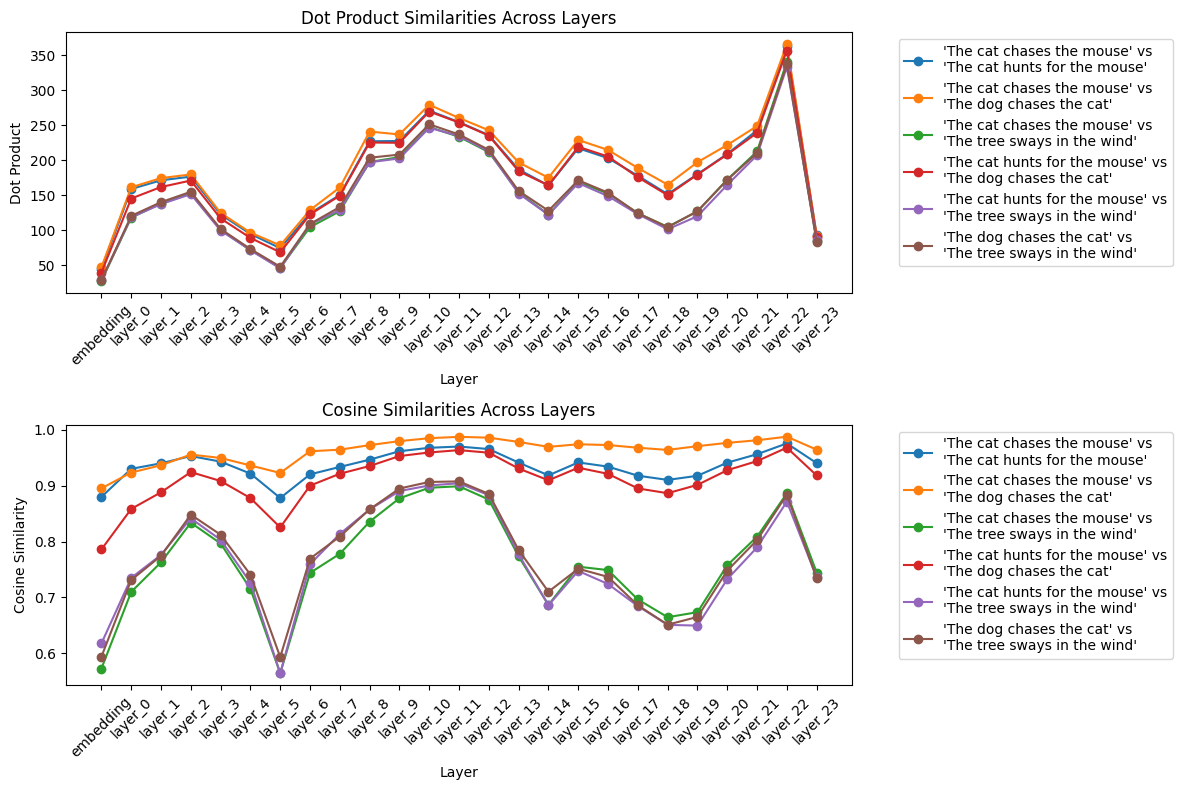


Detailed Similarity Changes:

Layer: embedding
Dot product (cat chases vs cat hunts): 44.664
Cosine sim (cat chases vs cat hunts): 0.880
Dot product (cat chases vs tree sways): 28.034
Cosine sim (cat chases vs tree sways): 0.573

Layer: layer_0
Dot product (cat chases vs cat hunts): 159.128
Cosine sim (cat chases vs cat hunts): 0.930
Dot product (cat chases vs tree sways): 118.344
Cosine sim (cat chases vs tree sways): 0.710

Layer: layer_1
Dot product (cat chases vs cat hunts): 171.528
Cosine sim (cat chases vs cat hunts): 0.940
Dot product (cat chases vs tree sways): 138.338
Cosine sim (cat chases vs tree sways): 0.763

Layer: layer_2
Dot product (cat chases vs cat hunts): 176.744
Cosine sim (cat chases vs cat hunts): 0.953
Dot product (cat chases vs tree sways): 152.740
Cosine sim (cat chases vs tree sways): 0.834

Layer: layer_3
Dot product (cat chases vs cat hunts): 122.851
Cosine sim (cat chases vs cat hunts): 0.943
Dot product (cat chases vs tree sways): 101.090
Cosine sim (cat

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_similarities(sentences, model_name='bert-large-uncased'):  # Changed to bert-large-uncased for 24 layers
    """Compare dot product and cosine similarities for a set of sentences"""
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()
    
    # Storage for layer-wise embeddings
    layer_embeddings = []
    
    def hook_fn(module, input, output):
        # Store the layer output, detached from computation graph
        layer_embeddings.append(output[0].detach())
    
    # Register hooks for each layer
    for layer in model.encoder.layer:
        layer.register_forward_hook(hook_fn)
    
    # Tokenize sentences
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
    
    # Get embeddings from each layer
    with torch.no_grad():
        _ = model(**inputs)
        
    # Process embeddings from each layer
    results = []
    
    # Add initial embedding layer
    with torch.no_grad():
        initial_embeddings = model.embeddings(inputs['input_ids'])
        mean_embeddings = (initial_embeddings * inputs['attention_mask'].unsqueeze(-1)).sum(1) / inputs['attention_mask'].sum(-1).unsqueeze(-1)
        results.append(("embedding", mean_embeddings))
    
    # Process each layer's embeddings
    for idx, layer_output in enumerate(layer_embeddings):
        # Mean pooling
        mask = inputs['attention_mask'].unsqueeze(-1)
        mean_embeddings = (layer_output * mask).sum(1) / mask.sum(1)
        results.append((f"layer_{idx}", mean_embeddings))
    
    # Compute similarities for each layer
    similarities = []
    for layer_name, embeddings in results:
        # Compute dot product
        dot_prod = torch.matmul(embeddings, embeddings.T)
        
        # Compute cosine similarity
        norms = torch.norm(embeddings, p=2, dim=1)
        cosine_sim = dot_prod / torch.outer(norms, norms)
        
        # Store results, converting to numpy arrays
        similarities.append({
            'layer': layer_name,
            'dot_product': dot_prod.cpu().numpy(),
            'cosine': cosine_sim.cpu().numpy(),
            'norms': norms.cpu().numpy()
        })
    
    return similarities

def plot_sentence_similarities(similarities, sentences):
    """Plot similarity changes through layers for specific sentence pairs"""
    n_layers = len(similarities)
    
    # Prepare data for plotting
    layers = [sim['layer'] for sim in similarities]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Plot dot products
    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            dot_products = [sim['dot_product'][i,j] for sim in similarities]
            ax1.plot(range(n_layers), dot_products, 
                    label=f"'{sentences[i]}' vs\n'{sentences[j]}'",
                    marker='o')
    
    ax1.set_title('Dot Product Similarities Across Layers')
    ax1.set_xlabel('Layer')
    ax1.set_ylabel('Dot Product')
    ax1.set_xticks(range(n_layers))
    ax1.set_xticklabels(layers, rotation=45)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot cosine similarities
    for i in range(len(sentences)):
        for j in range(i+1, len(sentences)):
            cosine_sims = [sim['cosine'][i,j] for sim in similarities]
            ax2.plot(range(n_layers), cosine_sims, 
                    label=f"'{sentences[i]}' vs\n'{sentences[j]}'",
                    marker='o')
    
    ax2.set_title('Cosine Similarities Across Layers')
    ax2.set_xlabel('Layer')
    ax2.set_ylabel('Cosine Similarity')
    ax2.set_xticks(range(n_layers))
    ax2.set_xticklabels(layers, rotation=45)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig

# Example usage
test_sentences = [
    "The cat chases the mouse",         # Basic animal action
    "The cat hunts for the mouse",      # Similar meaning, different words
    "The dog chases the cat",           # Related but different
    "The tree sways in the wind"        # Completely different topic
]

# Run analysis
similarities = compare_similarities(test_sentences)

# Plot results
fig = plot_sentence_similarities(similarities, test_sentences)
plt.show()

# Print some specific comparisons
print("\nDetailed Similarity Changes:")
for layer_idx, sim in enumerate(similarities):
    print(f"\nLayer: {sim['layer']}")
    print(f"Dot product (cat chases vs cat hunts): {sim['dot_product'][0,1]:.3f}")
    print(f"Cosine sim (cat chases vs cat hunts): {sim['cosine'][0,1]:.3f}")
    print(f"Dot product (cat chases vs tree sways): {sim['dot_product'][0,3]:.3f}")
    print(f"Cosine sim (cat chases vs tree sways): {sim['cosine'][0,3]:.3f}")